In [ ]:
!pip install tensorflow

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.15.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
data= pd.read_csv("dataset-ner.csv")

### Preproses

In [ ]:
print(data.isnull().sum())

sentence    0
word        0
pos         0
tag         0
dtype: int64


In [ ]:
data.head()

,sentence,word,pos,tag
0,Pertunjukan teater klasik akan diadakan di ged...,Pertunjukan,NN,O
1,Pertunjukan teater klasik akan diadakan di ged...,teater klasik,NN,O
2,Pertunjukan teater klasik akan diadakan di ged...,akan,MD,O
3,Pertunjukan teater klasik akan diadakan di ged...,diadakan,VB,O
4,Pertunjukan teater klasik akan diadakan di ged...,di,IN,O


In [ ]:
print("Unique Words in corpus:",data['word'].nunique())
print("Unique Tag in corpus:",data['tag'].nunique())

Unique Words in corpus: 328
Unique Tag in corpus: 6


In [ ]:
words = list(set(data['word'].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data['tag'].values))
num_tags = len(tags)

Menghitung jumlah kata dan tag unik dalam DataFrame, dan membuat list kata dan tag unik tersebut. “ENDPAD” ditambahkan sebagai kata tambahan untuk menandai akhir kalimat.

In [ ]:
num_words, num_tags

(329, 6)

In [ ]:
class SentanceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['word'].tolist(),s['pos'].tolist(),s['tag'].tolist())]
    self.grouped = self.data.groupby("sentence").apply(agg_func)
    self.sentances = [s for s in self.grouped]

SentanceGetter digunakan untuk mengelompokkan kata-kata dan tag-tag yang berhubungan dalam satu kalimat.

In [ ]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [ ]:
sentances[0]

[('Acara', 'NN', 'O'),
 ('peluncuran produk terbaru', 'NN', 'O'),
 ('akan', 'MD', 'O'),
 ('digelar', 'VB', 'O'),
 ('besok', 'NN', 'WAKTU'),
 ('di', 'IN', 'O'),
 ('pusat perbelanjaan', 'NN', 'LOKASI'),
 ('.', '.', 'O')]

In [ ]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

Membuat dua dictionary, word2idx dan tag2idx, yang masing-masing memetakan kata dan tag ke indeks unik.

In [ ]:
word2idx

{'bioskop': 1,
 'menikmati': 2,
 'hadir': 3,
 'harga': 4,
 'sejarah': 5,
 'keuntungan': 6,
 'sering': 7,
 'kafe': 8,
 'ke': 9,
 'rilis': 10,
 'diskon': 11,
 'secara': 12,
 'online': 13,
 'perusahaan XYZ': 14,
 'mohon': 15,
 'lewatkan': 16,
 'kunjungi': 17,
 'danau': 18,
 'panel': 19,
 'kantor': 20,
 'rencana': 21,
 'resep': 22,
 'Buku': 23,
 'teknologi': 24,
 'Besok': 25,
 'inspirasi': 26,
 'Acara': 27,
 'Harap': 28,
 'laboratorium': 29,
 'Mohon': 30,
 'pemasaran online': 31,
 'proposal bisnis': 32,
 'Surabaya': 33,
 'aplikasi': 34,
 'oleh': 35,
 'Promosi': 36,
 'pesta': 37,
 'diterima': 38,
 'dipamerkan': 39,
 'kerjasama baru': 40,
 'Silakan': 41,
 'tentang lingkungan': 42,
 'pusat perbelanjaan': 43,
 'bekerja': 44,
 'Peluncuran': 45,
 'tentang perkembangan teknologi terkini': 46,
 'LMN': 47,
 'lisa': 48,
 'membutuhkan': 49,
 'perjanjian': 50,
 'terkini': 51,
 'tenang': 52,
 'cabang': 53,
 'konser': 54,
 'berkunjung': 55,
 'pantai': 56,
 'akan': 57,
 'Minggu': 58,
 'lisa@email.com': 5

In [ ]:
tag2idx

{'O': 0, 'LOKASI': 1, 'PERUSAHAAN': 2, 'TAG_EMAIL': 3, 'EMAIL': 4, 'WAKTU': 5}

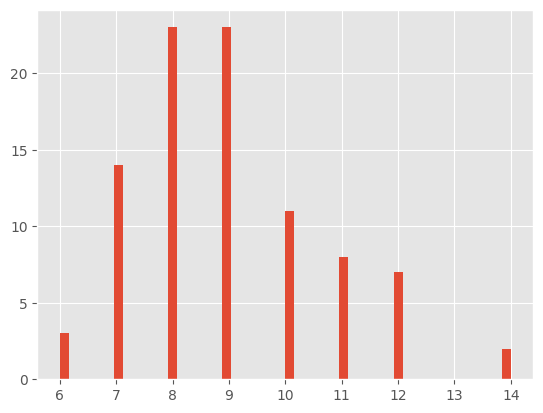

In [ ]:
plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

mempersiapkan data input dan output untuk proses training model dengan melakukan tokenisasi, padding, dan one-hot encoding.







### Model

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            16450     
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 6)             1206      
 ributed)                                                        
                                                             

mendefinisikan arsitektur model deep learning untuk tugas Named Entity Recognition (NER) menggunakan Keras.

In [ ]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

#### Training

In [ ]:
# early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
# callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 200,
    verbose = 1,
    # callbacks=callbacks
)

Epoch 1/200
1/1 [==============================] - 15s 15s/step - loss: 1.8004 - accuracy: 0.0194 - val_loss: 1.7498 - val_accuracy: 0.9353
Epoch 2/200
1/1 [==============================] - 1s 632ms/step - loss: 1.7496 - accuracy: 0.9416 - val_loss: 1.6977 - val_accuracy: 0.9624
Epoch 3/200
1/1 [==============================] - 0s 383ms/step - loss: 1.6986 - accuracy: 0.9597 - val_loss: 1.6415 - val_accuracy: 0.9624
Epoch 4/200
1/1 [==============================] - 0s 392ms/step - loss: 1.6416 - accuracy: 0.9597 - val_loss: 1.5778 - val_accuracy: 0.9624
Epoch 5/200
1/1 [==============================] - 1s 735ms/step - loss: 1.5784 - accuracy: 0.9597 - val_loss: 1.5029 - val_accuracy: 0.9624
Epoch 6/200
1/1 [==============================] - 0s 419ms/step - loss: 1.5042 - accuracy: 0.9597 - val_loss: 1.4116 - val_accuracy: 0.9624
Epoch 7/200
1/1 [==============================] - 1s 508ms/step - loss: 1.4118 - accuracy: 0.9597 - val_loss: 1.2964 - val_accuracy: 0.9624
Epoch 8/200
1/

#### Evaluasi

In [ ]:
model.evaluate(x_test, np.array(y_test))

1/1 [==============================] - 0s 84ms/step - loss: 0.1131 - accuracy: 0.9740


[0.11306504160165787, 0.9739999771118164]

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))

1/1 [==============================] - 0s 44ms/step
Word           True 	 Pred

------------------------------
Proyek         O    	O
pengembangan   O    	O
aplikasi       O    	O
dimulai        O    	O
minggu         WAKTU	O
depan          WAKTU	WAKTU
.              O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis      O    	O
strategis  

### Inference

In [ ]:
def predict_tags(text):
    words = text.split()
    x_test_sent = [word2idx.get(w, num_words-1) for w in words]
    x_test_sent = pad_sequences([x_test_sent], maxlen=max_len, padding='post', value=num_words-1)
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}{:5}\n".format("Word", "Pred"))
    print("-"*30)
    for w, pred in zip(words, p[0]):
        print("{:15}:{:5}".format(w, tags[pred]))

predict_tags("Saya akan menghadiri konser di Jakarta pada hari Sabtu.")


1/1 [==============================] - 0s 43ms/step
Word           Pred 

------------------------------
Saya           :O    
akan           :O    
menghadiri     :O    
konser         :O    
di             :O    
Jakarta        :O    
pada           :O    
hari           :WAKTU
Sabtu.         :O    


In [ ]:
predict_tags("Tolong kirimkan beberapa dokumen ke email lisa dari perusahaan BP di alamat lisa@email.com.")

1/1 [==============================] - 0s 46ms/step
Word           Pred 

------------------------------
Tolong         :O    
kirimkan       :O    
beberapa       :O    
dokumen        :O    
ke             :O    
email          :O    
lisa           :O    
dari           :O    
perusahaan     :PERUSAHAAN
BP             :PERUSAHAAN
di             :O    
alamat         :O    
lisa@email.com.:O    


In [ ]:
predict_tags("Mohon kirimkan rincian kontrak ke email saya di john@email.com secepatnya.")

1/1 [==============================] - 0s 45ms/step
Word           Pred 

------------------------------
Mohon          :O    
kirimkan       :O    
rincian        :O    
kontrak        :O    
ke             :O    
email          :O    
saya           :O    
di             :O    
john@email.com :O    
secepatnya.    :O    


In [ ]:
from tensorflow.keras.models import load_model

model.save('ner-lstm.h5')

# loaded_model = load_model('ner-lstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
